In [1]:
import pandas as pd
import numpy as np
import json
import gensim
from nltk.tokenize import word_tokenize
import fasttext
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
with open('../data/uml_extracted_metadata_annotated.json') as json_file:
    data = json.load(json_file)

    english_data = {
        file: data[file]
        for file in data.keys()
        if data[file]['lang'] == '__label__en'
    }

In [3]:
# Store all classes and attributes independent of eachother
all_classes = []
all_attrs = []

# Loop over all metadata and append to proper list
for file, metadata in english_data.items():
    if 'classes' in metadata.keys():
        all_classes.append(metadata['classes'])

    if 'attributes' in metadata.keys():
        all_attrs.append(metadata['attributes'])

# Create big dataframe with all values together
flatten = lambda t: [item for sublist in t for item in sublist]
df = pd.DataFrame(list(map(lambda x: [x, 'class'], flatten(all_classes))) + list(map(lambda x: [x, 'attribute'], flatten(all_attrs))), columns=['name', 'type'])

In [4]:
df.drop_duplicates(keep=False, inplace=True)

In [5]:
df['tokenized_length'] = df['name'].apply(lambda x: len(word_tokenize(x)))
df = df[df['tokenized_length'] == 1]

In [6]:
PRETRAINED_MODEL_PATH = '../data/lid.176.bin'

model = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [7]:
df['lang'] = df['name'].apply(lambda x: model.predict(x)[0][0])

In [8]:
df = df[df['lang'] == '__label__en']

In [9]:
vocab = [word_tokenize(row) for row in df['name'].to_list()]

In [10]:
word2vecSG = gensim.models.Word2Vec(vocab, min_count = 1, window = 5, sg = 1)

In [11]:
filtered_df = pd.concat([df[df['type'] == 'class'][:100], df[df['type'] == 'attribute'][100:200]])

In [17]:
filtered_df['vector'] = filtered_df['name'].apply(lambda x: word2vecSG.wv.get_vector(x))

In [12]:
alternated = []

for index in range(int(len(filtered_df) / 2)):
    alternated.append(filtered_df[filtered_df['type'] == 'class'].iloc[index].values)
    alternated.append(filtered_df[filtered_df['type'] == 'attribute'].iloc[index].values) 

column_names = filtered_df.columns
filtered_df = pd.DataFrame(alternated, columns = column_names)

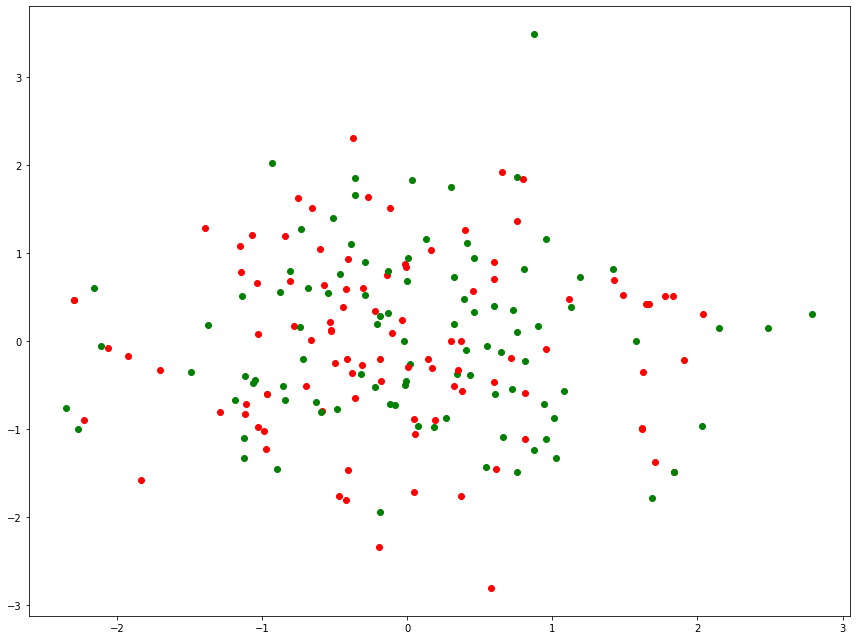

In [18]:
# define the words to visualize

topterms = {name: 1 for name in filtered_df['name'].to_list()}


vectors = filtered_df['vector'].to_list()
#tsne = TSNE(n_components=2, random_state=0)
#vectors2d = tsne.fit_transform(vectors)
pca = PCA(n_components=2, whiten=True)
vectors2d = pca.fit(vectors).transform(vectors)
#print(vectors2d)
plt.figure(figsize=(12,9))
alternate = True
first = True # color alternation to divide given groups
for point, word in zip(vectors2d , topterms):
    # plot points
    plt.scatter(point[0], point[1], c='r' if first else 'g')
    # plot word annotations
    plt.annotate(
        '',
        xy = (point[0], point[1]),
        xytext = (-7, -6) if first else (7, -6),
        textcoords = 'offset points',
        ha = 'right' if first else 'left',
        va = 'bottom',
        size = "x-large"
    )
    first = not first if alternate else first

plt.tight_layout()
plt.show()



In [13]:
model = gensim.models.FastText(vocab, min_count=1)

In [14]:
filtered_df['vector'] = filtered_df['name'].apply(lambda x: model.wv.get_vector(x))

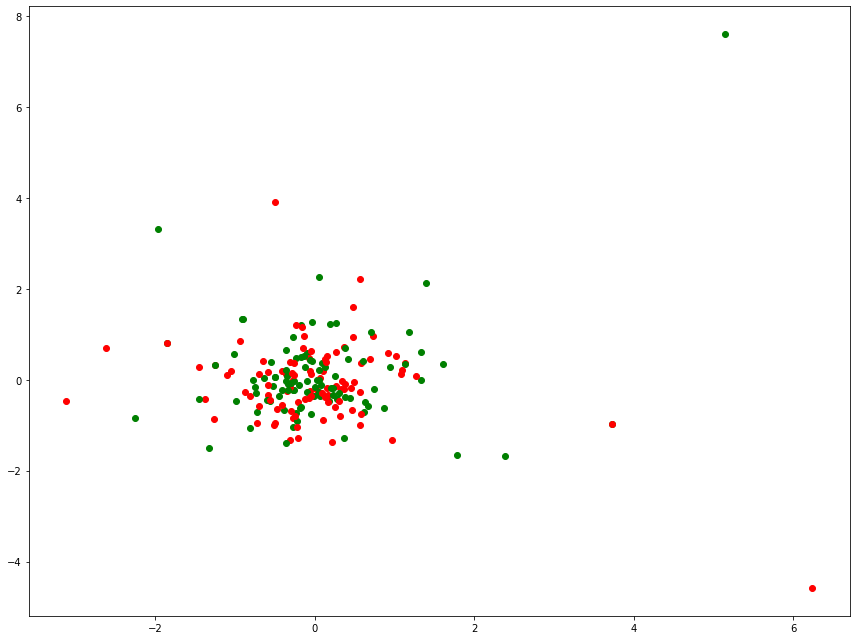

In [16]:
# define the words to visualize

topterms = {name: 1 for name in filtered_df['name'].to_list()}


vectors = filtered_df['vector'].to_list()
#tsne = TSNE(n_components=2, random_state=0)
#vectors2d = tsne.fit_transform(vectors)
pca = PCA(n_components=2, whiten=True)
vectors2d = pca.fit(vectors).transform(vectors)
#print(vectors2d)
plt.figure(figsize=(12,9))
alternate = True
first = True # color alternation to divide given groups
for point, word in zip(vectors2d , topterms):
    # plot points
    plt.scatter(point[0], point[1], c='r' if first else 'g')
    # plot word annotations
    plt.annotate(
        '',
        xy = (point[0], point[1]),
        xytext = (-7, -6) if first else (7, -6),
        textcoords = 'offset points',
        ha = 'right' if first else 'left',
        va = 'bottom',
        size = "x-large"
    )
    first = not first if alternate else first

plt.tight_layout()
plt.show()

